# Code to Analyze Neutron Scattering from $\rm{Nd_3Sb_3Mg_2O_{14}}$

Allen Scheie
December, 2017

We're already fit the point charge model, and now we're going to fit the CEF parameters directly.

In [1]:
# Import libraries
%matplotlib notebook
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
import sys
import CEF_calculations as cef
import time


#Plot Formatting stuff
#########################################################################
#mpl.style.use('default')
import seaborn.apionly as sns
from cycler import cycler
cpal1 = sns.choose_colorbrewer_palette('qualitative')

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans',
          'xtick.direction':'in', 'ytick.direction': 'in',
          'xtick.top': True,'ytick.right': True,
          'font.size': 15, 'axes.prop_cycle': cycler('color',cpal1)}
plt.rcParams.update(params)

def my_formatter(x, pos):
    """Format 0.0 as 0"""
    if x == 0.00: return '{:g}'.format(x)
    else: return x
#########################################################################


# Put the above values for the Debye Waller factor in a dictionary
AtomDisp = {}
AtomDisp['NdMg'] = {}
AtomDisp['NdMg'][6] = 0.0
AtomDisp['NdMg'][100] = 0.045148437500000055
AtomDisp['NdMg'][200] = 0.084953125000000129

AtomDisp['NdZn'] = {}
AtomDisp['NdZn'][6] = 0.0
AtomDisp['NdZn'][100] = 0.045175781250000054
AtomDisp['NdZn'][200] = 0.087765625000000125

AtomDisp['PrMg'] = {}
AtomDisp['PrMg'][6] = 0.0
AtomDisp['PrMg'][100] = 0.045941406250000053
AtomDisp['PrMg'][200] = 0.076910156250000111

/home/allen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


A Jupyter Widget

[6, 6, 6, 100, 100, 100, 200, 200, 200]
[40, 80, 150, 40, 80, 150, 40, 80, 150]


<IPython.core.display.Javascript object>


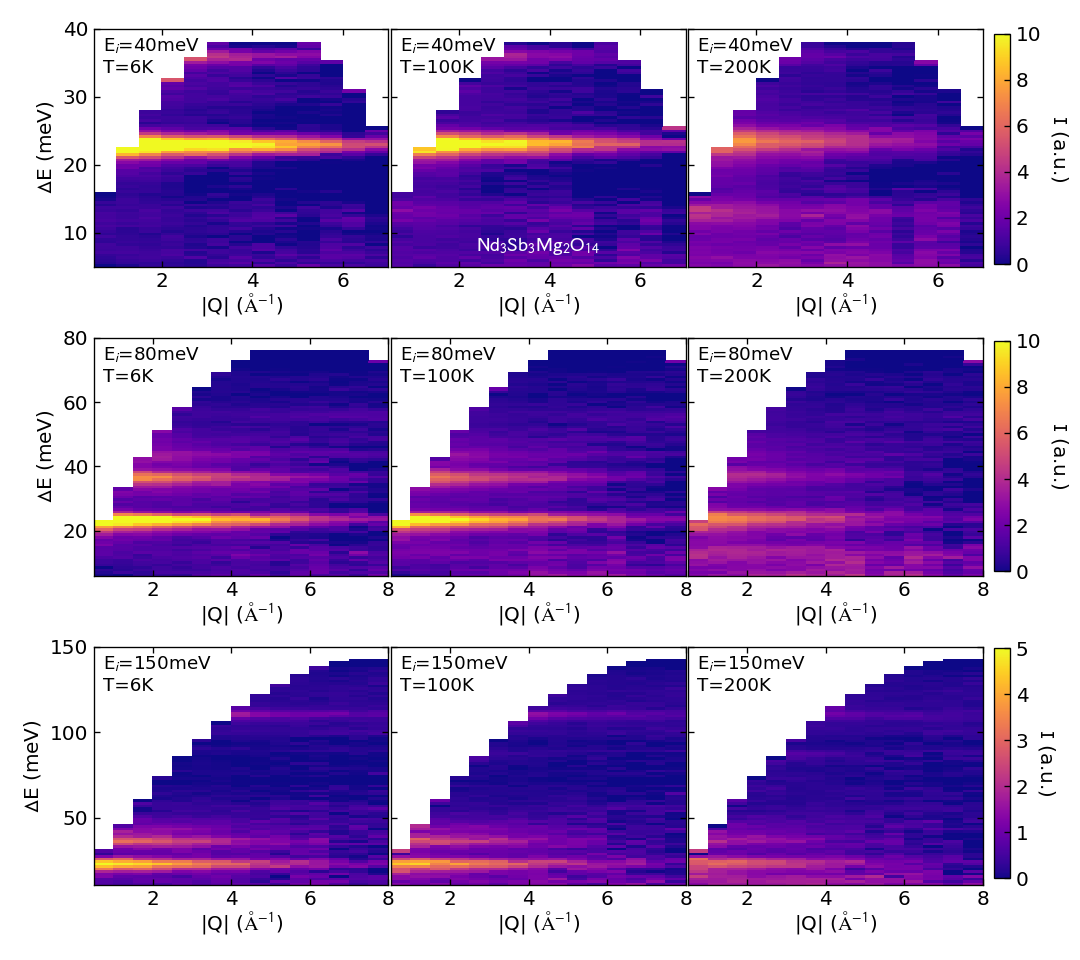

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [2]:
# Import Resolution Function

resf150 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc150.txt', skip_header=1, unpack=True)
resf80 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc80.txt', skip_header=1, unpack=True)
resf40 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc40.txt', skip_header=1, unpack=True)

def resfunc(Ei, deltaE):
    if Ei == 150:
        deltaE = np.interp(deltaE, resf150[0], resf150[1])
    elif Ei == 80:
        deltaE =  np.interp(deltaE, resf80[0], resf80[1])
    elif Ei == 40:
        deltaE =  np.interp(deltaE, resf40[0], resf40[1])
    else: print("Ei not in resfunc data.")
    return deltaE



# Test out NeutronSpectrum2D function
Qarray = np.arange(0.1,15,0.1)
Earray = np.arange(5,150,0.5)

def arrayedges(xarray):
    diff = (xarray[1:] - xarray[:-1]) / 2.  # get edges of arrays
    return np.hstack((xarray[0]-diff[0], xarray[:-1]+diff, xarray[-1]+diff[-1]))
Eedges = arrayedges(Earray)
Qedges = arrayedges(Qarray)




# Import data
slicesdirectory = './Data/Slices/'

# Define file names by my naming convention
filenames = []
for T in [6, 100, 200]:
    for E in [40,80,150]:
        filenames.append('NdMg_T'+str(T)+'_E'+str(E)+'_slice.iexy')

data = [cef.importGridfile(slicesdirectory+f) for i,f in enumerate(filenames)]
# # Intensity Error |Q| DeltaE

datatemps = [int(name.split('_')[1][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION
dataengys = [int(name.split('_')[2][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION

print(datatemps)
print(dataengys)

#print data[1][0]
ObsEnergies = np.array([  0., 0., 22.82, 22.82, 36.4, 36.4,
                        43.0,  43.0,  110.9,  110.9])


ntemps = len(set(datatemps))
nengys = len(set(dataengys))


plt.rc('font',**{'size':12})
    
f, ax = plt.subplots(3,3, figsize=(9,8))


cax1 = f.add_axes([0.92,0.725,0.015,0.24])
cax2 = f.add_axes([0.92,0.405,0.015,0.24])
cax3 = f.add_axes([0.92,0.085,0.015,0.24])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.001),(0,0.001),(0,0.0005)]
cmap = 'plasma'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    for j in range(ntemps):
        k = j*ntemps + i
        try: 
            intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
            ax[i,j].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                               rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
            # Set axis labels
            if j == 0: ax[i,j].set_ylabel('$\Delta$E (meV)')
            else: ax[i,j].yaxis.set_ticklabels([])
            ax[i,j].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
            # set text in frame
            ax[i,j].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=11,
                        horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
        except IndexError:
            break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 17)

ax[0,1].text(0.5,0.04,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$', color='w',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01, hspace=0.3, right=0.91)
plt.show()






### Import Susceptibility data
# Import data
datafile = './Data/'+\
                'Nd3Sb3Mg2O14 MT 1.8 to 300 5000 oe 53.8 mg.dc.dat'
#ImportData
DataA = np.genfromtxt(datafile, delimiter=',', skip_header=31)
Temp = DataA[:,3]
Mag = DataA[:,4]

#Normalize the data
mass = 0.0538 #mass in g of sample
Molarmass = 3*144.242 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
field = 5000

NormMag = Mag / mass * Molarmass / 3 / field
Chiminus1 = 1/NormMag  # in emu/Oe/mol
Chiminus1 *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion

## Import results of point charge model fit

In [3]:
import pickle

with open('./intermediateCoupling/'+\
          'CEF_ND_PC_fitResults.pickle', 'rb') as f:
    Nd3fit, FitVals, NdLigB = pickle.load(f)
    
FitGamma, FitPrefactors = FitVals['gamma'], FitVals['prefacs']

# Adjust Gammas and Prefactors so they're closer to the real thing.
FitGamma = np.array([ 2.74300718,  3.32043618,  5.02533437])
FitGamma *= 0.75
FitPrefactors = np.array([ 0.00167644,  0.00153931,  0.00077782])
FitPrefactors *= 2

# Fit Stevens Operators to data

The point charge model does not work perfectly. Now we want to take the stevens operators defined by the model and fit them to the data.

In [4]:
NdLigB

array([ -9.27263177e-02,  -6.04553278e-01,  -1.15157835e-01,
        -7.87991552e-03,   1.70236762e-03,  -1.58283563e-03,
        -6.40573823e-02,   3.44292949e-03,  -7.76002969e-05,
        -3.20727858e-07,   6.52078413e-05,   8.55332069e-04,
        -8.63140892e-05,  -2.70153050e-04,  -8.99940537e-04])

In [5]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ionJ = cef.Jion['Nd3+']
# Spin orbit coupling strength = hc * First Excited Multiplet Energy (in cm) / 5.5
SOCstrength = 1.23984193e-1 * 1936 / 5.5
print(ionJ)
# Take final ligand values from above
Coefficients = NdLigB

i=0
Nd_O = []
for n in range(2,8,2):
    for m in range(0,n+1):
        #print(n,m, Coefficients[i])
        Nd_O.append(  cef.LS_StevensOp(ionJ[1],ionJ[0],n,m)  )
        i+=1
        
Nd = cef.LS_CFLevels(Nd_O, Coefficients, ionJ[1], ionJ[0], SOCstrength)

Nd.diagonalize()
Nd.printEigenvectors()
Nd.gsExpectation()


def err_global2D(CFLevelsObject, coeff, gamma, prefacs, ObsEigenvals, NeutronData, 
                SusceptibilityData, temps, energies, ResFunc, AtomDisp, Ion):
    """Global error to all functions passed to it, used for fitting"""
    prefs = np.tile( prefacs , len(set(energies)))
    gamms = np.repeat(gamma, len(set(temps)))

    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    # Compute error in eigenvalue
    try: erro=sum((CFLevelsObject.eigenvalues[:len(ObsEigenvals)].real - ObsEigenvals)**2)*500
    except TypeError:  erro = 1000000

    # Compute error in neutron spectrum
    for i in range(len(temps)):
        errspec = (np.abs(prefs[i])*\
                CFLevelsObject.neutronSpectrum2D(Earray=NeutronData[i]['E'], Qarray = NeutronData[i]['Q'], 
                            Temp=temps[i],
                            Ei = energies[i], ResFunc=lambda de: ResFunc(energies[i],de), 
                            gamma=gamms[i], DebyeWaller=AtomDisp[temps[i]], Ion=Ion) ) -\
                NeutronData[i]['I']
        erro += np.nansum((errspec/NeutronData[i]['dI'])**2)  # Chisq with uncertainty

#     # Compute error in susceptibility
#     try: 
#         SusceptibilityData[0]  #just test whether susceptibility is indexable
#         # The first index of susceptibility should be temperature, the other the data.
#         calcsuscep = CFLevelsObject.susceptibilityDeriv(SusceptibilityData[0], 0.5, 0.001)

#         erro += np.sum((SusceptibilityData[1] + 1/calcsuscep)**2)*100

#     except TypeError:  pass
    
#     # Compute error in saturation magnetization
#     satB, satM = 8.924693, 1.32221992622
#     calcsatM = np.zeros((3,3))
#     calcsatM[0] = CFLevelsObject.magnetizationDeriv(2, [satB,0,0], 0.001)
#     calcsatM[1] = CFLevelsObject.magnetizationDeriv(2, [0,satB,0], 0.001)
#     calcsatM[2] = CFLevelsObject.magnetizationDeriv(2, [0,0,satB], 0.001)
#     avgcalcsatM = -(calcsatM[0,0] + calcsatM[1,1] + calcsatM[2,2])/3.

#     #print(avgcalcsatM, satM)
#     erro += (avgcalcsatM - satM)**2 * 1e4
        
    # Constraints
    constraint = 0

    #return err0 + constraint
    sys.stdout.write("\r err = "+str(erro))
    sys.stdout.flush() # important for printing progress
    return erro + constraint

[1.5, 6.0, 4.5]
43.642435936

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.    -0.001 -0.006 -0.876  0.001  0.003  0.31   0.045 -0.001 -0.118
 -0.035 -0.013  0.038  0.02   0.015 -0.002 -0.007 -0.01  -0.012 -0.044
  0.004  0.005  0.055  0.007  0.005 -0.049 -0.003 -0.081  0.031 -0.003
  0.126 -0.004  0.006 -0.138  0.013 -0.003  0.101 -0.022  0.009 -0.014
  0.021 -0.015  0.036 -0.002  0.018 -0.082  0.004 -0.     0.216 -0.005  0.
 -0.001]  |
0.00000 	|  [-0.001 -0.    -0.005 -0.216  0.     0.004  0.082  0.018 -0.002 -0.036
 -0.015 -0.021  0.014  0.009  0.022  0.101 -0.003 -0.013 -0.138 -0.006
  0.004  0.126  0.003  0.031 -0

In [6]:
#************************************************************
# Fit to neutron data

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes1 = Nd.fitdata(chisqfunc = err_global2D,  fitargs = ['coeff'], method = 'Nelder-Mead',
            coeff = Coefficients, gamma=FitGamma, prefacs=FitPrefactors,
            ObsEigenvals = ObsEnergies, NeutronData = data, SusceptibilityData = [Temp,Chiminus1],
            temps = datatemps, energies = dataengys,
            ResFunc = resfunc, AtomDisp = AtomDisp['NdMg'], Ion = 'Nd3+'
                         )
##############################################################################################
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 err = 617614.065555Initial err= 617614.065555 

 err = 160366.852413160366.852413
 err = 617614.065555617614.065555
Initial err = 617614.065555 	Final err = 160366.852413


In [9]:
with open('./intermediateCoupling/'+\
          'CEF_ND_fitResults.pickle', 'wb') as f:
    pickle.dump((FitCoefRes1, FitGamma, FitPrefactors), f)

In [10]:
NdCoefFit1 = cef.LS_CFLevels(Nd_O, FitCoefRes1['coeff'], ionJ[1], ionJ[0], SOCstrength)
NdCoefFit1.diagonalize()
NdCoefFit1.printEigenvectors()
NdCoefFit1.gsExpectation()

43.642435936

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.    -0.002 -0.427  0.    -0.001  0.157  0.017  0.002 -0.075
 -0.012  0.018  0.034  0.005 -0.023  0.041 -0.001  0.018 -0.074  0.004
 -0.009  0.066 -0.002 -0.019 -0.039 -0.     0.032 -0.075  0.002 -0.039
  0.139 -0.006  0.036 -0.193  0.016  0.006  0.204 -0.025 -0.014  0.026
  0.024  0.023 -0.09   0.002 -0.032  0.251 -0.004 -0.    -0.767  0.01
  0.001 -0.002]  |
0.00000 	|  [-0.002 -0.001  0.01   0.767  0.    -0.004 -0.251 -0.032  0.002  0.09
  0.023 -0.024 -0.026 -0.014  0.025  0.204  0.006 -0.016 -0.193 -0.036
  0.006  0.139  0.039  0.002 -0.075 -0.032 -0.